In [3]:
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from python_speech_features import logfbank
import os
import librosa
import librosa.display
from scipy.io.wavfile import write
import random

## 1.分析数据

In [15]:
length=[]
paths=[r"C:\Users\Forre\Desktop\final_project\DAIC\f_nor",\
       r"C:\Users\Forre\Desktop\final_project\DAIC\m_nor",\
       r"C:\Users\Forre\Desktop\final_project\DAIC\f_depr",\
       r"C:\Users\Forre\Desktop\final_project\DAIC\m_depr"]
for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1]=='.wav':
                y, sr = librosa.load(root+'\\'+file, sr=None)
                length.append(len(y)/sr)

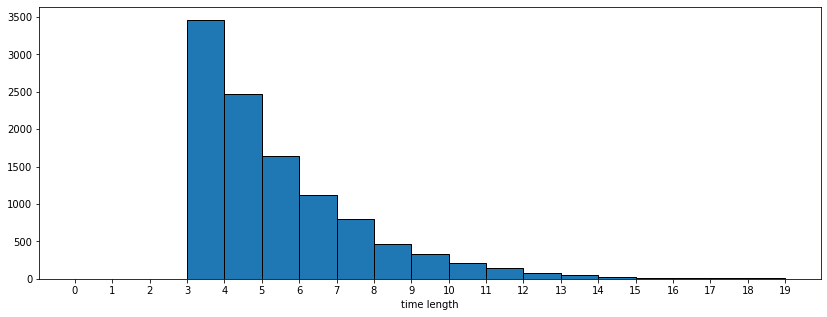

In [40]:
plt.figure(figsize=(14,5))
plt.hist(length,bins=range(20),edgecolor="black")
plt.xlabel('time length')
plt.xticks(range(20))
plt.show()

所有utterance的时长分布,可以发现语料最短3s,最长19s，大部分在10s以内

## 2.数据预处理

### 2.1消噪

(128, 63)


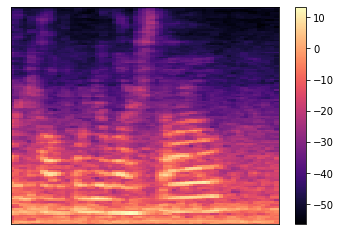

(128, 653)


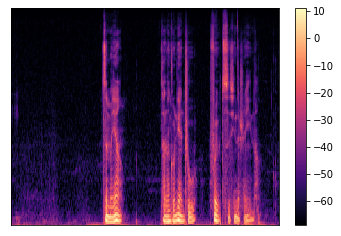

In [114]:
y, sr = librosa.load("test/308_9_1.wav", sr=None)
melspec=librosa.feature.melspectrogram(y,sr)
logmelspec=librosa.power_to_db(melspec)
librosa.display.specshow(logmelspec,cmap='magma')
plt.colorbar()
print(logmelspec.shape)
plt.show()
y, sr = librosa.load("test/003.wav", sr=None)
melspec=librosa.feature.melspectrogram(y,sr)
logmelspec=librosa.power_to_db(melspec)
librosa.display.specshow(logmelspec,cmap='magma')
plt.colorbar()
print(logmelspec.shape)
plt.show()

暂时不消噪

### 2.2 裁切语料片段

In [16]:
def utterance_cut(source_path,target_path,cut_len):
    for root, dirs, files in os.walk(source_path):
        for file in files:
            if os.path.splitext(file)[1]=='.wav':
                y, sr = librosa.load(root+'\\'+file, sr=None)
                segnum=int(len(y)/(cut_len*sr))
                for i in range(segnum):
                    write(target_path+'\\'+os.path.splitext(file)[0]+'_'+str(i)+".wav"\
                          ,sr,y[int(i*sr*cut_len):int((i+1)*sr*cut_len)])
## 将所有source_path里的wav文件取整切割成cut_len长度的语料，并且将裁切后的片段存储到target_path

In [17]:
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\f_nor"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_3s\nor",3)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\m_nor"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_3s\nor",3)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\f_depr"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_3s\depr",3)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\m_depr"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_3s\depr",3)

裁切成3s片段

In [19]:
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\f_nor"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_2s\nor",2)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\m_nor"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_2s\nor",2)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\f_depr"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_2s\depr",2)
utterance_cut(r"C:\Users\Forre\Desktop\final_project\DAIC\m_depr"\
              ,r"C:\Users\Forre\Desktop\final_project\seg_2s\depr",2)

裁切成2s片段

### 2.2 加窗分帧以及特征提取

In [97]:
def get_size(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1]=='.wav':
                y, sr = librosa.load(root+'\\'+file, sr=None)
                melspec=librosa.feature.melspectrogram(y,sr)
                size=melspec.shape
                break
    num_of_utterance=0
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1]=='.wav':
                num_of_utterance+=1
    size=[num_of_utterance,size[0],size[1]]
    return size
## 返回目标源经过梅尔倒谱后的尺寸

In [100]:
def get_logmelspec(path):
    size=get_size(path)
    temp=np.empty(size,dtype=float)
    i=0
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1]=='.wav':
                y, sr = librosa.load(root+'\\'+file, sr=None)
                melspec=librosa.feature.melspectrogram(y,sr)
                temp[i,:,:]=logmelspec=librosa.power_to_db(melspec)
                i=i+1
    return temp
## 返回目标源所有wav文件经过梅尔倒谱后得到的特征向量

In [161]:
def normalize_depr_nor(depr,nor):
    data=np.concatenate((depr,nor),axis=0)
    scale=np.amax(data)-np.amin(data)
    mid=(np.amax(data)+np.amin(data))/2
    data=2*(data-mid)/scale
    len_depr=depr.shape[0]
    len_nor=nor.shape[0]
    depr=data[0:len_depr,:,:]
    nor=data[len_depr:len_depr+len_nor,:,:]
    return (depr,nor)
## 对depr和nor特征向量同时做max_min归一化

In [167]:
depr_2s=get_logmelspec(r"C:\Users\Forre\Desktop\final_project\seg_2s\depr")
depr_3s=get_logmelspec(r"C:\Users\Forre\Desktop\final_project\seg_3s\depr")
nor_2s=get_logmelspec(r"C:\Users\Forre\Desktop\final_project\seg_2s\nor")
nor_3s=get_logmelspec(r"C:\Users\Forre\Desktop\final_project\seg_3s\nor")
depr_2s,nor_2s=normalize_depr_nor(depr_2s,nor_2s)
depr_3s,nor_3s=normalize_depr_nor(depr_3s,nor_3s)

In [174]:
np.save("data/depr_2s",depr_2s)
np.save("data/nor_2s",nor_2s)
np.save("data/depr_3s",depr_3s)
np.save("data/nor_3s",nor_3s)

**将处理后的训练数据保存，之后可以直接Load**

In [4]:
depr_2s=np.load("data/depr_2s.npy")
nor_2s=np.load("data/nor_2s.npy")
depr_3s=np.load("data/depr_3s.npy")
nor_3s=np.load("data/nor_3s.npy")

In [5]:
def balance(depr,nor):
    balance_size=min(depr.shape[0],nor.shape[0])
    return (depr[0:balance_size,:,:] ,nor[0:balance_size,:,:])
##裁切depr和nor语料数量，使之平衡

In [22]:
depr_2s,nor_2s=balance(depr_2s,nor_2s)
depr_3s,nor_3s=balance(depr_3s,nor_3s)

In [40]:
x_2s.shape

(14196, 128, 63)

In [39]:
x_2s.reshape(1,*x_2s.shape).shape

(1, 14196, 128, 63)

In [45]:
x_2s=np.concatenate((depr_2s,nor_2s),axis=0)
x_3s=np.concatenate((depr_3s,nor_3s),axis=0)
y_2s=np.concatenate((np.ones(depr_2s.shape[0]),np.zeros(depr_2s.shape[0])),axis=0)
y_3s=np.concatenate((np.ones(depr_3s.shape[0]),np.zeros(depr_3s.shape[0])),axis=0)

In [56]:
from sklearn.model_selection import train_test_split
x_train_2s,x_test_2s,y_train_2s,y_test_2s=train_test_split(x_2s,y_2s,test_size=0.3,random_state=7)
x_train_3s,x_test_3s,y_train_3s,y_test_3s=train_test_split(x_3s,y_3s,test_size=0.3,random_state=7)
## random_state是随机数种子，同样的种子可以得到相同的划分

In [57]:
x_train_2s=x_train_2s.reshape(*x_train_2s.shape,1)
x_test_2s=x_test_2s.reshape(*x_test_2s.shape,1)
x_train_3s=x_train_3s.reshape(*x_train_3s.shape,1)
x_test_3s=x_test_3s.reshape(*x_test_3s.shape,1)

## 3.创建CNN模型

尝试API写法

In [34]:
from keras import Input,layers,Model
input_tensor=Input(shape=(128,63,1))
conv1a=layers.Conv2D(8,(2,8),activation='relu',padding='same')(input_tensor)
conv1b=layers.Conv2D(8,(8,2),activation='relu',padding='same')(input_tensor)
conv1 = layers.concatenate([conv1a,conv1b],axis=-1)
MaxPooling=layers.MaxPooling2D(2,2)(conv1)
conv2=layers.Conv2D(32,(3,3),activation='relu',padding = 'same')(MaxPooling)
MaxPooling=layers.MaxPooling2D(2,2)(conv2)
conv3=layers.Conv2D(128,(3,3),activation='relu',padding = 'same')(MaxPooling)
MaxPooling=layers.MaxPooling2D(2,2)(conv3)
dropout=layers.Dropout(0.15)(MaxPooling)
flatten=layers.Flatten()(MaxPooling)
dense=layers.Dense(128,activation='relu')(flatten)
dropout=layers.Dropout(0.5)(dense)
output_tensor=layers.Dense(1,activation='sigmoid')(dropout)
API_model=Model(input_tensor,output_tensor)
API_model.summary()

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 63, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 63, 8)   136         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 63, 8)   136         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 63, 16)  0           conv2d_1[0][0]         

In [51]:
API_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [58]:
history=API_model.fit(x_train_2s,y_train_2s, validation_data=(x_test_2s,y_test_2s), epochs=2,batch_size=128)




Train on 9937 samples, validate on 4259 samples
Epoch 1/2





9937/9937 [==============================] - 49s 5ms/step - loss: 0.6880 - acc: 0.5665 - val_loss: 0.6830 - val_acc: 0.6201
Epoch 2/2
9937/9937 [==============================] - 50s 5ms/step - loss: 0.6796 - acc: 0.5950 - val_loss: 0.6739 - val_acc: 0.6323


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

In [290]:
#create model
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(128,63,1)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

存在过拟合问题

In [1]:
hist=model.fit(X_2s,Y_2s, validation_data=(x_2s,y_2s), epochs=2,batch_size=128)

NameError: name 'model' is not defined

In [297]:
hist.history

{'val_loss': [1.0704536437988281, 1.069960355758667],
 'val_acc': [0.7574999928474426, 0.7649999856948853],
 'loss': [0.22434218201472275, 0.20804321426725966],
 'acc': [0.9027549970849845, 0.9101344773948447]}

In [294]:
score = model.evaluate(x_2s, y_2s, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0935435778851388
Test accuracy: 0.7665


In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 126, 198, 8)       80        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 99, 8)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 61, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 48, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 23, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 21, 64)        18496     
__________

In [298]:
predict=model.predict(x_2s)
count=0
for i,j in enumerate(predict):
    if(j>=0.5)&(y_2s[i]==1):
        count=count+1
    if(j<0.5)&(y_2s[i]==0):
        count=count+1
print(count)

1530


改进

In [ ]:
path=r"C:\Users\Forre\Desktop\final_project\DAIC\f_depr"
f_depr=pd.DataFrame()
for root, dirs, files in os.walk(path):
    print(root)
    for file in files:
        if os.path.splitext(file)[1]=='.wav':
            y, sr = librosa.load(root+'\\'+file, sr=None)
            df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
            df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
            df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
            df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
            df=pd.concat([df1,df2,df3,df4],axis=1)
            df.columns=range(df.shape[1])
            f_depr=f_depr.append(df)

试着提取mfcc,czr,f0,帧带宽

In [30]:
y, sr = librosa.load('308_20.wav', sr=None)
df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
df=pd.concat([df1,df2,df3,df4],axis=1)
df.columns=range(df.shape[1])

C:\Users\Forre\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


FileNotFoundError: [Errno 2] No such file or directory: '308_20.wav'

In [85]:
path=r"C:\Users\Forre\Desktop\final_project\DAIC\f_depr"
f_depr=pd.DataFrame()
for root, dirs, files in os.walk(path):
    print(root)
    for file in files:
        if os.path.splitext(file)[1]=='.wav':
            y, sr = librosa.load(root+'\\'+file, sr=None)
            df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
            df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
            df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
            df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
            df=pd.concat([df1,df2,df3,df4],axis=1)
            df.columns=range(df.shape[1])
            f_depr=f_depr.append(df)
path=r"C:\Users\Forre\Desktop\final_project\DAIC\f_nor"
f_nor=pd.DataFrame()
for root, dirs, files in os.walk(path):
    print(root)
    for file in files:
        if os.path.splitext(file)[1]=='.wav':
            y, sr = librosa.load(root+'\\'+file, sr=None)
            df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
            df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
            df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
            df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
            df=pd.concat([df1,df2,df3,df4],axis=1)
            df.columns=range(df.shape[1])
            f_nor=f_nor.append(df)
path=r"C:\Users\Forre\Desktop\final_project\DAIC\m_depr"
m_depr=pd.DataFrame()
for root, dirs, files in os.walk(path):
    print(root)
    for file in files:
        if os.path.splitext(file)[1]=='.wav':
            y, sr = librosa.load(root+'\\'+file, sr=None)
            df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
            df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
            df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
            df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
            df=pd.concat([df1,df2,df3,df4],axis=1)
            df.columns=range(df.shape[1])
            m_depr=m_depr.append(df)
path=r"C:\Users\Forre\Desktop\final_project\DAIC\m_nor"
m_nor=pd.DataFrame()
for root, dirs, files in os.walk(path):
    print(root)
    for file in files:
        if os.path.splitext(file)[1]=='.wav':
            y, sr = librosa.load(root+'\\'+file, sr=None)
            df1=pd.DataFrame(librosa.feature.mfcc(y,sr).transpose())
            df2=pd.DataFrame(librosa.feature.zero_crossing_rate(y,sr).transpose())
            df3=pd.DataFrame(librosa.feature.spectral_centroid(y,sr).transpose())
            df4=pd.DataFrame(librosa.feature.spectral_bandwidth(y,sr).transpose())
            df=pd.concat([df1,df2,df3,df4],axis=1)
            df.columns=range(df.shape[1])
            m_nor=m_nor.append(df)

C:\Users\Forre\Desktop\final_project\DAIC\f_nor
C:\Users\Forre\Desktop\final_project\DAIC\m_depr
C:\Users\Forre\Desktop\final_project\DAIC\m_nor


In [10]:
f_nor[13]=0
f_depr[13]=1
train_nor=f_nor[0:20000]
train_depr=f_depr[0:20000]
train=train_nor.append(train_depr)
test_nor=f_nor[20000:40000]
test_depr=f_depr[20000:40000]
test=test_nor.append(test_depr)
X=train.iloc[:,0:12]
Y=train.iloc[:,13]
x=test.iloc[:,0:12]
y=test.iloc[:,13]

In [17]:
data=train.append(test)
target=data.iloc[:,13]
data=data.iloc[:,0:12]

PCA对得到的训练以及测试数据的特征向量进行降维

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pC = pca.fit_transform(data)
pC=pd.DataFrame(pC)

In [42]:
X=pC[0:15000].append(pC[20000:35000])
Y=target[0:15000].append(target[20000:35000])
x=pC[15000:20000].append(pC[35000:40000])
y=target[15000:20000].append(target[35000:40000])

In [44]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, Y)
predict=clf.predict(x)

C:\Users\Forre\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


统计预测正确率：
5866/10000=58.66%

In [45]:
count=0
for i,j in enumerate(predict):
    if j!=list(y)[i]:
        count=count+1
print(count)

4134
